In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 

from makeEnv import acousticEnv
from normalMode import Chinook
from beamformers import bartlet, MVDR, wnc, wnc_bisection

In [21]:
# Pekeris enviornment
f = 45
c_w = 1500
rho_w = 1000
c_b = 1800
rho_b = 1800
atten_b = 0.2
d = 100
rMax = 5000

world = acousticEnv()
world.pekeris(c_w, c_b, rho_w, rho_b, atten_b, d)

In [22]:
#array specification
numR = 10
# dR = (c_w / f) / 2
dR = 5
startDepth = 90  # measured from bottom
rDepth = startDepth - np.arange(numR) * dR

In [23]:
# Source location
sD = 20
sR = 3000

In [24]:
nm_model = Chinook(f, world)
nm_model.calculateModes_shooting()

In [25]:
zPlot = np.r_[0:d:100j]
rPlot = np.r_[10:rMax:200j]
p_nm = nm_model.calculatePressure(sD, zPlot, rPlot)

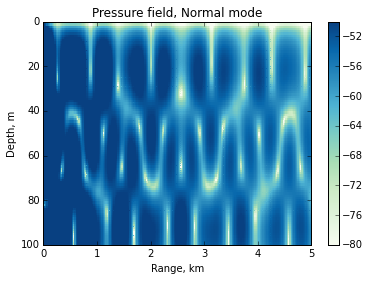

In [26]:
R_nm, Z = np.meshgrid(p_nm.index, p_nm.columns)
TL_nm = 20 * np.log10(np.abs(p_nm.T))
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(TL_nm), cmap = plt.cm.GnBu)
_ = plt.clim(-80, -50)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(d,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [27]:
# Construct MF library
lookVectors = np.dstack([nm_model.calculatePressure(r, zPlot, rPlot)\
                 for r in rDepth])
# range compensation
lookVectors = lookVectors / np.linalg.norm(lookVectors, axis = 2)[:,:,None]
lookVectors = np.nan_to_num(lookVectors)
shape_3d = lookVectors.shape
lookVectors = np.reshape(lookVectors,\
                         (shape_3d[0] * shape_3d[1], shape_3d[2]))

In [28]:
# construct data vector
data = nm_model.calculatePressure(sD, rDepth, sR)
K = np.outer(data, np.array(data).conj())

In [29]:
# beamforming step
B_bart = bartlet(K, lookVectors)
B_bart = np.reshape(B_bart, (shape_3d[0], shape_3d[1]))
B_bart = 10 * np.log10(np.abs(B_bart.T + np.spacing(1)))
B_bart = B_bart - np.max(B_bart)

In [30]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart), cmap = plt.cm.GnBu)
plt.plot(sR / 1e3, sD, 'r*')

_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(d,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [31]:
# beamforming step
B_MVDR = MVDR(K, lookVectors)
B_MVDR = np.nan_to_num(B_MVDR)
B_MVDR = np.reshape(B_MVDR, (shape_3d[0], shape_3d[1]))
B_MVDR = 10 * np.log10(np.abs(B_MVDR.T + np.spacing(1)))
B_MVDR = B_MVDR - np.max(B_MVDR)

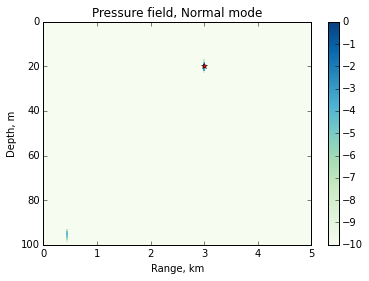

In [32]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_MVDR), cmap = plt.cm.GnBu)
plt.plot(sR / 1e3, sD, 'r*')

_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(d,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [33]:
# beamforming step
B_wnc = wnc(K, lookVectors, 2)
B_wnc = np.nan_to_num(B_wnc)
B_wnc = np.reshape(B_wnc, (shape_3d[0], shape_3d[1]))
B_wnc = 10 * np.log10(np.abs(B_wnc.T + np.spacing(1)))
B_wnc = B_wnc - np.max(B_wnc)

In [42]:
%time B_wnc = wnc(K, lookVectors, 2)
B_wnc = np.nan_to_num(B_wnc)
B_wnc = np.reshape(B_wnc, (shape_3d[0], shape_3d[1]))
B_wnc = 10 * np.log10(np.abs(B_wnc.T + np.spacing(1)))
B_wnc = B_wnc - np.max(B_wnc)

CPU times: user 2.57 s, sys: 36.9 ms, total: 2.61 s
Wall time: 2.61 s


In [43]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_wnc), cmap = plt.cm.GnBu)
_ = plt.plot(sR / 1e3, sD, 'r*')
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(d,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [44]:
%time B_wnc_2 = wnc_bisection(K, lookVectors, 2)
B_wnc_2 = np.nan_to_num(B_wnc_2)
B_wnc_2 = np.reshape(B_wnc_2, (shape_3d[0], shape_3d[1]))
B_wnc_2 = 10 * np.log10(np.abs(B_wnc_2.T + np.spacing(1)))
B_wnc_2 = B_wnc_2 - np.max(B_wnc_2)

CPU times: user 1.16 s, sys: 27.1 ms, total: 1.18 s
Wall time: 1.18 s


In [45]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_wnc_2), cmap = plt.cm.GnBu)
_ = plt.plot(sR / 1e3, sD, 'r*')
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(d,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')